# **Traffic sign detection using T-FasterRCNN model**


---


Traffic sign detection is a hotspot of research and development by the onset of semi-automatic and fully automatic cars in the market. However, the low visibility scenarios due to bad weather, reflections, and night time can cause a system failure in these cars. Improving traffic sign detection system vision in real-time can reduce accidents and also regulates drivers to follow traffic rules.

Below are the implementation of various experiments and results comparions to give answers to following research questions:



1. Can transfer learning when applied to real-time traffic sign classification accelerate the prediction of FasterRCNN and RCNN?
2. Can transfer learned FasterRCNN achieve improved performance in terms of accuracy and F1 score for real-time traffic sign classifications?
3. Can image/traffic sign blurriness affect the performance of transfer learned FasterRCNN for real-time traffic sign classification?




## **Import Libraries**


---


The code is importing all the neccessary libraries which are going to be used in the experiments, such as os, cv2, tensorflow, keras, numpy and others.

In [ ]:
# Fetching essential libraries
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import torch
import math
import shutil
import pathlib
import random
import numpy as np
import torchvision
import pandas as pd
from time import time
from glob import glob
from tqdm import tqdm
from PIL import Image
import transforms as T
from imageio import imread
from torch.utils import data
import matplotlib.pyplot as plt

#Tensorflow stable version
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import he_normal, zeros, glorot_normal, RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2
from google.colab import files

#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.random.set_seed(42)


## **Data Processing**


---



Dataset will be download via Kaggle links using google colab upload file library.

In [ ]:
def kaggle_dataset() :
  print('Please upload the kaggle api token :')
  files.upload() #upload kaggle.json file
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # assigning privelidges

  #extract dataset in /content/Data
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data
  

# trigger downloading
kaggle_dataset()

Creates a directory named plots that will contain all the graphs exported in the svg format.

In [ ]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


## **Data Analysis**


---


Few methods of plotting the correlation matrix and and bar graphs to represent data analysis on GTSRB graphically.

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(figsize=(6,6))
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.savefig(f'/content/plots/metacorr_{filename}.svg')
    plt.show()
   

    
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow, name="default"):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (18, 4), dpi = 80)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
        plt.grid(False)
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig(f'../content/plots/plotcol_{name}.svg')
    plt.show() #this


In [ ]:
def resize_cv(im):
    return cv2.resize(im, (64, 64), interpolation = cv2.INTER_LINEAR)

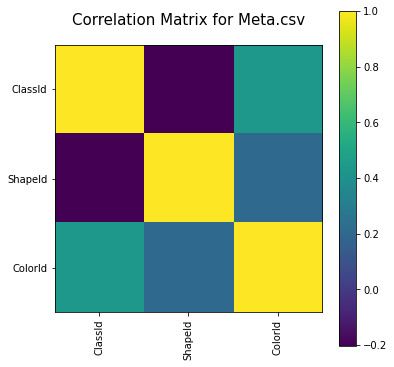

<Figure size 800x800 with 0 Axes>

In [ ]:
# Data Visualizations
meta_file = pd.read_csv("/content/Data/Meta.csv")
meta_file.dataframeName = 'Meta.csv'
plotCorrelationMatrix(meta_file, 10)


In [ ]:

# Data viusalizations 
list_images = []
output = []
train_file = pd.read_csv("/content/Data/Train.csv")

train_file.dataframeName = 'Train.csv'
for index, row in train_file.iterrows():
    img_path = '/content/Data/' +  row['Path']
    img=imread(img_path)
    img = img[row['Roi.X1']:row['Roi.X2'],row['Roi.Y1']:row['Roi.Y2'],:]
    img = resize_cv(img)
    list_images.append(img)
    output.append(row.ClassId)

plt.figure(figsize=(6,4))
plt.hist(output, bins=43, histtype='stepfilled', color='steelblue',
                edgecolor='none');
plt.title("Traffic signs frequency graph")
plt.xlabel("ClassId")
plt.ylabel("Frequency")
# plt.savefig('../thesis/plots/metaplots/frequency.svg')
train_file

Displaying few traffic signs images to showcase the type of data available.

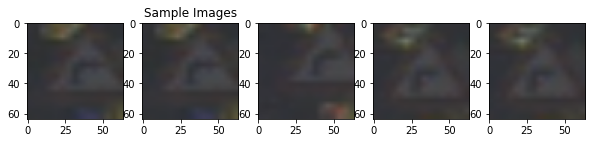

In [ ]:
example_im=[]
for i in range(5):
    random_filename = random.choice([
        x for x in list_images
    ])
    example_im.append(random_filename)
    
fig = plt.figure(figsize=(10, 210))
ax=[]
for i in range(5):
    ax.append( fig.add_subplot(20, 5, i+1) )
    plt.imshow(example_im[i])
    
ax[1].set_title("Sample Images")
plt.show() 

<Figure size 800x800 with 0 Axes>

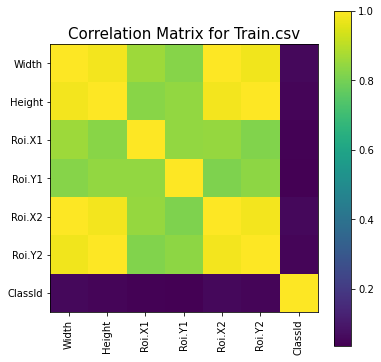

In [ ]:
# Correlation Matrix
plotCorrelationMatrix(train_file, 10)




### **Analysis of Training and Testing Datasets**

---
This sections aims to find the common dimensions in the testing and training datasets which can be feed as an input to the model while training.


Text(0.5, 1.0, 'Histogram: Height distribution of Images in training data')

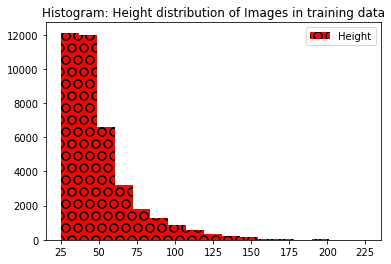

In [ ]:
# Training Images dimensions
plt.hist(train_file.Height, 'sturges', color = 'r' , label = 'Height', hatch= 'O')
plt.legend()
plt.grid(False)
plt.title("Histogram: Height distribution of Images in training data") 
# plt.savefig('../thesis/plots/metaplots/training_hieght_distribution.svg')

Text(0.5, 1.0, 'Histogram: Width distribution of Images in training data')

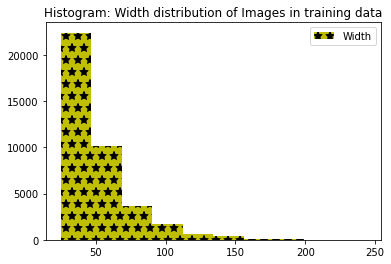

In [ ]:

plt.grid(False)
plt.hist(train_file.Width, 10, color = 'y' , label = 'Width', hatch='*')
plt.legend()

plt.title("Histogram: Width distribution of Images in training data") 
# plt.savefig('../thesis/plots/metaplots/training_width_distribution.svg')

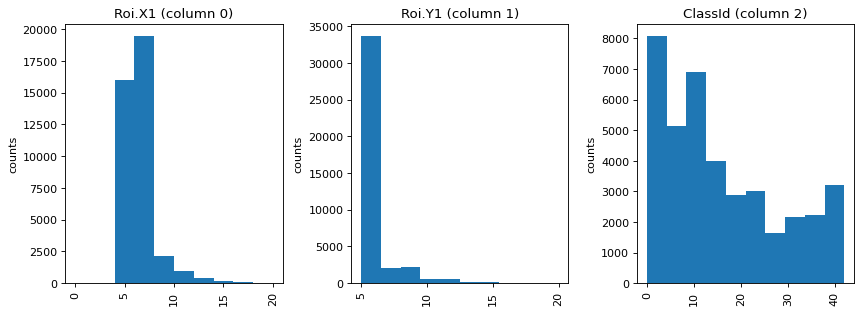

In [ ]:
# Test file
plotPerColumnDistribution(train_file, 10, 5, "train")


Text(0, 0.5, 'Frequency')

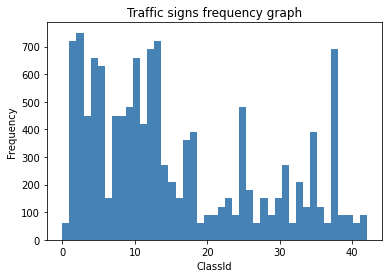

In [ ]:
# Test files
# Data viusalizations 
list_images = []
output = []
test_file = pd.read_csv("/content/Data/Test.csv")

test_file.dataframeName = 'Test.csv'
for index, row in test_file.iterrows():
    img_path = '/content/Data/' +  row['Path']
    img=imread(img_path)
    img = img[row['Roi.X1']:row['Roi.X2'],row['Roi.Y1']:row['Roi.Y2'],:]
    img = resize_cv(img)
    list_images.append(img)
    output.append(row.ClassId)


plt.figure(figsize=(6,4))
plt.hist(output, bins=43, histtype='stepfilled', color='steelblue',
                edgecolor='none');
plt.title("Traffic signs frequency graph")
plt.xlabel("ClassId")
plt.ylabel("Frequency")
# plt.savefig('../thesis/plots/metaplots/frequency.svg')


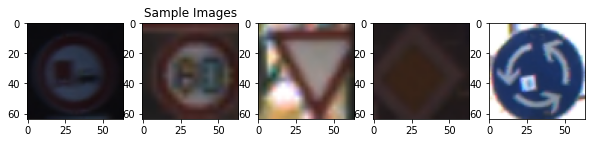

In [ ]:
example_im=[]
for i in range(5):
    random_filename = random.choice([
        x for x in list_images
    ])
    example_im.append(random_filename)
    
fig = plt.figure(figsize=(10, 210))
ax=[]
for i in range(5):
    ax.append( fig.add_subplot(20, 5, i+1) )
    plt.imshow(example_im[i])
    plt.grid(False)
    
ax[1].set_title("Sample Images")

plt.show()

<Figure size 800x800 with 0 Axes>

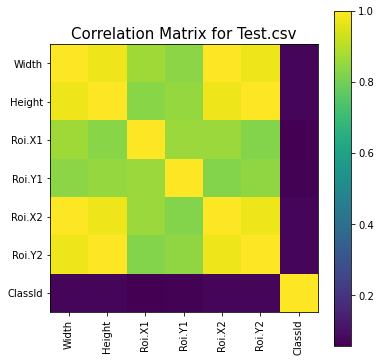

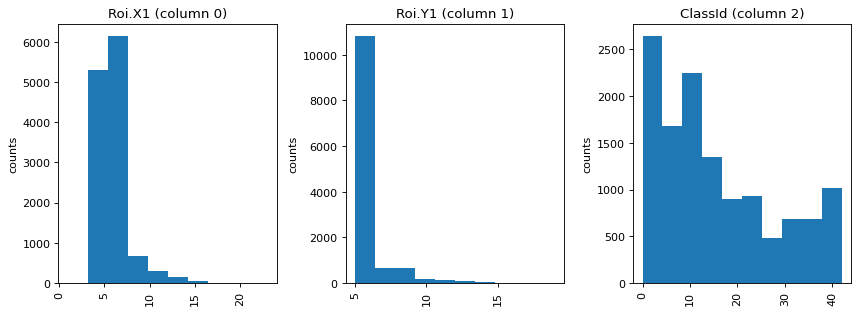

In [ ]:
plotCorrelationMatrix(test_file, 10)
plotPerColumnDistribution(test_file, 10, 5, "test")


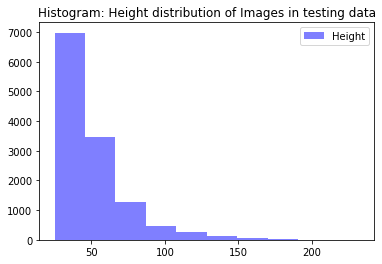

In [ ]:
# Training Images dimensions
plt.hist(test_file.Height, 10, alpha = 0.5, color = 'b' , label = 'Height')
plt.legend()
plt.title("Histogram: Height distribution of Images in testing data") 
plt.grid(False)
# plt.savefig('../thesis/plots/metaplots/test_height_dist.svg')

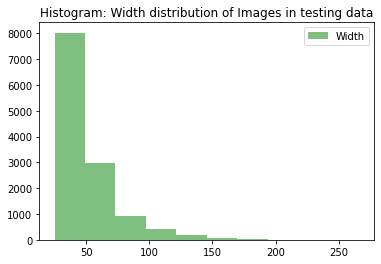

In [ ]:
plt.hist(test_file.Width, 10, alpha = 0.5, color = 'g' , label = 'Width')
plt.legend()
plt.title("Histogram: Width distribution of Images in testing data") 
plt.grid(False)
# plt.savefig('../thesis/plots/metaplots/test_width_dist.svg')

### **Creating Validation Dataset**

In [ ]:
#Run this only once
#Creating validation directory
val_dir = "/content/Data/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "/content/Data/Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/4))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 78.92it/s]


## **Data Preprocessing**


---

This section will perform modifications on the training and testing data and perform operations before the traning of the models to make it fit for the model. Also, the image size and width decided by the above visualizations will be set here. The pandas dataframes are initialized for both training and validation data.

In [ ]:
#Setting up variables
IMG_WIDTH = 30
IMG_HEIGHT = 30
N_CHANNELS = 3
BATCH_SIZE = 300
N_EPOCHS = 30
VAL_BATCH_SIZE = 100
CLASS_NAMES = list(range(43))
N_CLASSES = 43
train_path = "/content/Data/Train"         #Train dataset path
val_path = "/content/Data/Validation"      #Validation dataset path


#Path to train and validation datasets
data_root_train = pathlib.Path(train_path)
data_root_val = pathlib.Path(val_path)

#Getting paths to all the images in train and validation sets
all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_train = [str(path) for path in all_image_paths_train]

all_image_paths_val = list(data_root_val.glob('*/*'))
all_image_paths_val = [str(path) for path in all_image_paths_val]

#Counting number of images in each sets
image_count_train = len(all_image_paths_train)
image_count_val = len(all_image_paths_val)


In [ ]:
label_names_train = sorted(int(item.name) for item in data_root_train.glob('*/') if item.is_dir())
label_names_val = sorted(int(item.name) for item in data_root_val.glob('*/') if item.is_dir())
label_to_index_train = dict((name, index) for index,name in enumerate(label_names_train))
label_to_index_val = dict((name, index) for index,name in enumerate(label_names_val))
all_image_labels_train = [label_to_index_train[int(pathlib.Path(path).parent.name)] for path in all_image_paths_train]
all_image_labels_val = [label_to_index_val[int(pathlib.Path(path).parent.name)] for path in all_image_paths_val]


In [ ]:
#Loading dataframe
df_train = pd.read_csv("/content/Data/Train.csv")

#Updating coordinates
for idx, row in df_train.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    df_train.iloc[idx, 4] = df_train.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    df_train.iloc[idx, 5] = df_train.iloc[idx]['Roi.Y2'] + diff
df_train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,25,24,20,Train/20/00020_00000_00000.png
1,28,27,5,6,25,25,20,Train/20/00020_00000_00001.png
2,29,26,6,5,25,25,20,Train/20/00020_00000_00002.png
3,28,27,5,6,25,25,20,Train/20/00020_00000_00003.png
4,28,26,5,5,25,25,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,25,25,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,25,25,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,25,25,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,25,24,42,Train/42/00042_00007_00028.png


Altering the dimensions of the images.

In [ ]:
train_idx_list = []
val_idx_list = []

for path_tr in tqdm(all_image_paths_train) :
  train_idx_list.append(df_train[df_train['Path'] == path_tr[14 : ]].index[0])
for path_val in tqdm(all_image_paths_val) :
  path_val = "/content/Data/Train/" + path_val[25:]
  val_idx_list.append(df_train[df_train['Path'] == path_val[ 14:]].index[0])

new_df_train = pd.DataFrame()
new_df_val = pd.DataFrame()

new_df_train = new_df_train.append(df_train.iloc[train_idx_list], ignore_index = True)
new_df_val = new_df_val.append(df_train.iloc[val_idx_list], ignore_index = True)

new_df_train = new_df_train.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)
new_df_val = new_df_val.drop(['Height', 'Width', 'ClassId', 'Path'], axis = 1)

100%|██████████| 9812/9812 [00:27<00:00, 361.40it/s]


### **Data Generator**

In [ ]:
def tfdata_generator(images, labels, df, is_training, batch_size=32):
  '''Construct a data generator using tf.Dataset'''
  def parse_function(filename, labels, df):
    '''Function to preprocess the images'''
    #reading path 
    image_string = tf.io.read_file(filename)
    #decoding image
    image = tf.image.decode_png(image_string, channels=N_CHANNELS)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    #Adjusting contrast and brightness of the image
    if tf.math.reduce_mean(image) < 0.3 :
      image = tf.image.adjust_contrast(image, 5)
      image = tf.image.adjust_brightness(image, 0.2)
    #resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
    image = image/255.0
    #one hot coding for label
    #y = tf.one_hot(tf.cast(label, tf.uint8), N_CLASSES)
    return image, {"classification" : labels, "regression" : df}
  ##creating a dataset from tensorslices
  dataset = tf.data.Dataset.from_tensor_slices((images, labels, df))
  if is_training:
    dataset = dataset.shuffle(30000)  # depends on sample size
  # Transform and batch data at the same time
  dataset = dataset.map(parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  #prefetch the data into CPU/GPU
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

#Train and Validation data generators :
# print(all_image_paths_train)
# print(all_image_labels_train)
print(new_df_train)
tf_image_generator_train = tfdata_generator(all_image_paths_train, all_image_labels_train, new_df_train, is_training=True, batch_size=100)
tf_image_generator_val = tfdata_generator(all_image_paths_val, all_image_labels_val, new_df_val, is_training=False, batch_size=100)


       Roi.X1  Roi.Y1  Roi.X2  Roi.Y2
0           5       6      25      25
1           6       7      24      24
2           5       5      25      25
3          12      12      18      18
4           6       5      25      25
...       ...     ...     ...     ...
29392       5       6      25      25
29393       5       6      25      25
29394       5       6      25      25
29395       6       5      25      25
29396       5       5      25      25

[29397 rows x 4 columns]


## **Initialization of FasterRCNN model**


---

Faster RCNN is an object detection architecture presented by Ross Girshick, Shaoqing Ren, Kaiming He and Jian Sun in 2015, and is one of the famous object detection architectures that uses convolution neural networks like YOLO (You Look Only Once) and SSD ( Single Shot Detector).

In [ ]:
class Sharpen(tf.keras.layers.Layer):
  def __init__(self, num_outputs) :
      super(Sharpen, self).__init__()
      self.num_outputs = num_outputs

  def build(self, input_shape) :
      self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      self.kernel = tf.expand_dims(self.kernel, 0)
      self.kernel = tf.expand_dims(self.kernel, 0)
      self.kernel = tf.cast(self.kernel, tf.float32)

  def call(self, input_) :
      return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
      
def get_faster_rcnn_model() :
  #Input layer
  input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ), name="input_layer", dtype='float32')
  #Sharpen Layer to sharpen the edges of the image.
  sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ))(input_layer)
  #Convolution, maxpool and dropout layers
  conv_1 = Conv2D(filters=32, kernel_size=(5,5), activation=relu,
                  kernel_initializer=he_normal(seed=54), bias_initializer=zeros(),
                  name="first_convolutional_layer") (sharp)
  conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=55), bias_initializer=zeros(),
                  name="second_convolutional_layer") (conv_1)                  
  maxpool_1 = MaxPool2D(pool_size=(2,2), name = "first_maxpool_layer")(conv_2)
  dr1 = Dropout(0.25)(maxpool_1)
  conv_3 = Conv2D(filters=64, kernel_size=(3,3), activation=relu,
                  kernel_initializer=he_normal(seed=56), bias_initializer=zeros(),
                  name="third_convolutional_layer") (dr1)
  maxpool_2 = MaxPool2D(pool_size=(2,2), name = "second_maxpool_layer")(conv_3)
  dr2 = Dropout(0.25)(maxpool_2) 
  flat = Flatten(name="flatten_layer")(dr2)

  #Fully connected layers
  d1 = Dense(units=256, activation=relu, kernel_initializer=he_normal(seed=45),
            bias_initializer=zeros(), name="first_dense_layer_classification", kernel_regularizer = l2(0.001))(flat)
  dr3 = Dropout(0.5)(d1)
  
  classification = Dense(units = 43, activation=None, name="classification",  kernel_regularizer = l2(0.0001))(dr3)
  
  regression = Dense(units = 4, activation = 'linear', name = "regression", 
                    kernel_initializer=RandomNormal(seed=43), kernel_regularizer = l2(0.1))(dr3)
  #Model
  model = Model(inputs = input_layer, outputs = [classification, regression])
  model.summary()
  return model

## **Code to train the performance metrics for FasterRCNN**
The code not only evaluate the performance metrics here but also for training the model on the mentioned epochs.

In [ ]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, auc
import datetime
import time

#Defining cusotm callback for F1-Score
class Metrics(Callback) :
  """
  Custom callback to print the weighted F1-Score
  at the end of each training epoch.
  """
  def __init__(self, validation_data_generator) :
    self.validation_data_generator = validation_data_generator

  def on_train_begin(self, logs={}) :
    '''
    This function initializes lists to store AUC and Micro F1 scores
    '''
    self.val_f1s = []
    self.val_precisions = []
    self.val_recalls = []
    self.batches = self.validation_data_generator.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs = {}) :
    '''
    This function calculates the micro f1 and auc scores
    at the end of each epochs
    '''
    current_batch = self.batches.next()
    images = current_batch[0]
    labels = current_batch[1]
    labels = labels["classification"]
    labels = np.array(labels)
    pred = self.model.predict(images)
    pred = pred[0]
    val_predict = (np.asarray(pred)).round()
    idx = np.argmax(val_predict, axis=-1)
    a = np.zeros( val_predict.shape )
    a[ np.arange(a.shape[0]), idx] = 1
    val_predict = [np.where(r==1)[0][0] for r in a]
    val_predict = np.array(val_predict)
    val_targ = labels
    _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
    _val_precision = precision_score(val_targ, val_predict, average='weighted')
    _val_recall = recall_score(val_targ, val_predict, average='weighted')
    print("\nEpoch : {0} -  Precision_Score : {1:.2f} - Recall_Score : {2:.2f} - F1_Score : {3:.2f}\n".format(epoch, _val_precision, _val_recall, _val_f1))
    self.val_f1s.append(_val_f1)
    self.val_precisions.append(_val_precision)
    self.val_recalls.append(_val_recall)
    return

#Defining loss functions for classification and regression
#Loss function for bounding box regression
def r2_keras(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true - y_pred)) 
  SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#loss function for classification
loss = SparseCategoricalCrossentropy(from_logits=True)

#Compiling the model
model = get_faster_rcnn_model()
model.compile(optimizer="adam", loss = {"classification" : loss, "regression" : "mse"}, 
              metrics={"classification" : "acc", "regression" : r2_keras}, loss_weights = {"classification" : 5, "regression" : 1})

#Callbacks
#Tensorboard callback
%load_ext tensorboard
log_dir="/content/Data/drive/My Drive/expr1FRCNN/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                                   write_images = True)
#ModelCheckpoint
NAME = "TrafficSignRecog-first-cut-{0}".format(int(time.time()))
save_best_model = ModelCheckpoint(filepath='/content/Data/My Drive/expr1FRCNN/best_models/{0}'.format(NAME), monitor='val_loss',
                                  save_best_only = True, mode = 'min', save_freq = 'epoch')

#Early stopping to avoide model overfitting
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
metrics = Metrics(tf_image_generator_val)

#Training
history = model.fit_generator(
    generator = tf_image_generator_train, steps_per_epoch = 100, #train batch size
    epochs = N_EPOCHS,
    validation_data = tf_image_generator_val, validation_steps = 100, #val batch size
    callbacks = [save_best_model, tensorboard_callback, metrics, early_stop]
)
history_fastercnn = history

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 30, 30, 3)]  0                                            
__________________________________________________________________________________________________
sharpen (Sharpen)               (None, 30, 30, 3)    0           input_layer[0][0]                
__________________________________________________________________________________________________
first_convolutional_layer (Conv (None, 26, 26, 32)   2432        sharpen[0][0]                    
__________________________________________________________________________________________________
second_convolutional_layer (Con (None, 24, 24, 64)   18496       first_convolutional_layer[0][0]  
______________________________________________________________________________________________

In [ ]:
# Importing Image class from PIL module
from scipy.ndimage.filters import gaussian_filter

# Apply Image augmentation and model prediciton
def evaluate_model(path, model, level="level0") :
  final_image = labels = bbox = []
  # get the list of all testing images in sorted order
  all_imgs = os.listdir(path)
  all_imgs.sort()
  for img in tqdm(all_imgs) :
    if '.png' in img :
      image_string = tf.io.read_file(path + '/' + img)
      #Loading and decoding image
      image = tf.image.decode_png(image_string, channels=N_CHANNELS)
      #Converting image data type to float
      image = tf.image.convert_image_dtype(image, tf.float32)
      #Adjusting image brightness and contrast
      if tf.math.reduce_mean(image) < 0.3 :
        image = tf.image.adjust_contrast(image, 5)
        image = tf.image.adjust_brightness(image, 0.2)
      #Resizing image
      image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest", preserve_aspect_ratio=False)
      image = image/255.0
      image = np.expand_dims(image, axis=0)
      if level == "level5":
        image = gaussian_filter(image, sigma=2)
      elif level == "level10":
        image = gaussian_filter(image, sigma=3)
      elif level == "level15":
        image = gaussian_filter(image, sigma=4)
      final_image.append(image)
      pred = model.predict(image)
      labels.append(np.argmax(pred[0][0]))
      bbox.append(pred[1][0])
  return labels, bbox

### **Evaluating the test images for FasterRCNN model**

In [ ]:
from time import time
start_time = time()
labels, bbox = evaluate_test_images('/content/Data/Test/', model)
exp3_time = time() - start_time

100%|██████████| 12631/12631 [11:49<00:00, 17.81it/s]


In [ ]:
exp3_time = exp3_time/12631

In [ ]:
test_df = pd.read_csv('/content/Data/Test.csv')
for idx, row in test_df.iterrows() :
  w = row['Width']
  h = row['Height']
  if w > IMG_WIDTH :
    diff = w-IMG_WIDTH
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] - diff
  else :
    diff = IMG_WIDTH-w
    test_df.iloc[idx, 4] = test_df.iloc[idx]['Roi.X2'] + diff
  if h > IMG_HEIGHT :
    diff = h - IMG_HEIGHT
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] - diff
  else :
    diff = IMG_HEIGHT - h
    test_df.iloc[idx, 5] = test_df.iloc[idx]['Roi.Y2'] + diff

## **Visualization of Results**


---
Training and Validation loss


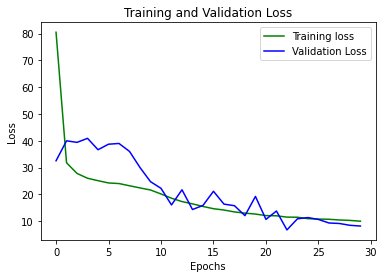

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])

epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.savefig('/content/plots/training_loss_fasterrcnn.svg')
plt.show()


Traning and Valdation accuracy among numner of epochs

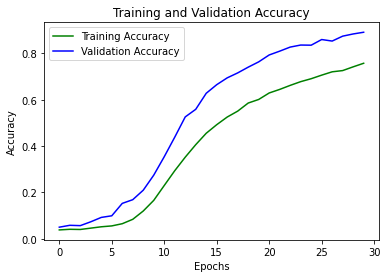

In [ ]:
acc_train = np.array(history.history['classification_acc'])
acc_val = np.array(history.history['val_classification_acc'])

epochs = range(0,30)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.savefig('/content/plots/training_accuracy_fasterrcnn.svg')
plt.show()

Calculating the metrcis for the testing results.

In [ ]:

from sklearn.metrics import f1_score, mean_squared_error, precision_score, recall_score, accuracy_score
exp3_accuracy = accuracy_score(test_df['ClassId'], labels)
exp3_precision = precision_score(test_df['ClassId'], labels, average='weighted')
exp3_recall = recall_score(test_df['ClassId'], labels, average='weighted')
exp3_f1_score = f1_score(test_df['ClassId'], labels, average = 'weighted')
exp3_mse = mean_squared_error(test_df.iloc[:, 2:6], bbox)

In [ ]:
print("Test Accuracy : {0:.2f}".format(exp3_accuracy))
print("Test Precision : {0:.2f}".format(exp3_precision))
print("Test Recall : {0:.2f}".format(exp3_recall))
print("Test f1-score : {0:.2f}".format(exp3_f1_score))
print("Test Mean squared error : {0:.2f}".format(exp3_mse))
print("Test Time: {0:.2f}".format(exp3_time))

Test Accuracy : 0.85
Test Precision : 0.86
Test Recall : 0.85
Test f1-score : 0.84
Test Mean squared error : 5.69
Test Time: 0.06


## **Data Augmentation for Blur level 1**

In [ ]:
# 5% changes
from time import time
start = time()
labels5, bbox5 = evaluate_test_images('/content/Data/Test/', model, "level5")
test_time = time() - start
test_time_l5 = test_time/12631


100%|██████████| 12631/12631 [11:39<00:00, 18.06it/s]


performance metrics 

In [ ]:
test_accuracy_l5 = accuracy_score(test_df['ClassId'], labels5)
test_precision_l5 = precision_score(test_df['ClassId'], labels5, average='weighted')
test_recall_l5 = recall_score(test_df['ClassId'], labels5, average='weighted')
test_f1_score_l5 = f1_score(test_df['ClassId'], labels5, average = 'weighted')
test_mse_l5 = mean_squared_error(test_df.iloc[:, 2:6], bbox5)

print("Test Accuracy level 5 : {0:.2f}".format(test_accuracy_l5))
print("Test Precision level 5 : {0:.2f}".format(test_precision_l5))
print("Test Recall level 5: {0:.2f}".format(test_recall_l5))
print("Test f1-score level 5: {0:.2f}".format(test_f1_score_l5))
print("Test Mean squared error level 5: {0:.2f}".format(test_mse_l5))
print("Test Time  level 5: {0:.2f}".format(test_time_l5))


Test Accuracy level 5 : 0.60
Test Precision level 5 : 0.64
Test Recall level 5: 0.60
Test f1-score level 5: 0.58
Test Mean squared error level 5: 554.04
Test Time  level 5: 0.06


## **Data Augmentation for Blur level 2**

In [ ]:
# 10% changes
from time import time
start = time()
labels10, bbox10 = evaluate_test_images('/content/Data/Test/', model, "level10")
test_time = time() - start

100%|██████████| 12631/12631 [11:38<00:00, 18.08it/s]


In [ ]:
test_time_l10 = test_time/12631

In [ ]:
test_accuracy_l10 = accuracy_score(test_df['ClassId'], labels10)
test_precision_l10 = precision_score(test_df['ClassId'], labels10, average='weighted')
test_recall_l10 = recall_score(test_df['ClassId'], labels10, average='weighted')
test_f1_score_l10 = f1_score(test_df['ClassId'], labels10, average = 'weighted')
test_mse_l10 = mean_squared_error(test_df.iloc[:, 2:6], bbox10)

print("Test Accuracy level10: {0:.2f}".format(test_accuracy_l10))
print("Test Precision level10: {0:.2f}".format(test_precision_l10))
print("Test Recall level10: {0:.2f}".format(test_recall_l10))
print("Test f1-score level10: {0:.2f}".format(test_f1_score_l10))
print("Test Mean squared error level10: {0:.2f}".format(test_mse_l10))
print("Test Time  level 10: {0:.2f}".format(test_time_l10))

Test Accuracy level10: 0.35
Test Precision level10: 0.50
Test Recall level10: 0.35
Test f1-score level10: 0.34
Test Mean squared error level10: 567.23
Test Time  level 10: 0.06


## **Data Augmentation for Blur level 3**

In [ ]:
# 15% changes
from time import time
start = time()
labels15, bbox15 = evaluate_test_images('/content/Data/Test/', model, "level15")
test_time = time() - start
test_time_l15 = test_time/12631

test_accuracy_l15 = accuracy_score(test_df['ClassId'], labels15)
test_precision_l15 = precision_score(test_df['ClassId'], labels15, average='weighted')
test_recall_l15 = recall_score(test_df['ClassId'], labels15, average='weighted')
test_f1_score_l15 = f1_score(test_df['ClassId'], labels15, average = 'weighted')
test_mse_l15 = mean_squared_error(test_df.iloc[:, 2:6], bbox15)

print("Test Accuracy level15: {0:.2f}".format(test_accuracy_l15))
print("Test Precision level15: {0:.2f}".format(test_precision_l15))
print("Test Recall level15: {0:.2f}".format(test_recall_l15))
print("Test f1-score level15: {0:.2f}".format(test_f1_score_l15))
print("Test Mean squared error level15: {0:.2f}".format(test_mse_l15))
print("Test Time  level 15: {0:.2f}".format(test_time_l15))

100%|██████████| 12631/12631 [11:45<00:00, 17.90it/s]

Test Accuracy level15: 0.17
Test Precision level15: 0.27
Test Recall level15: 0.17
Test f1-score level15: 0.15
Test Mean squared error level15: 574.44
Test Time  level 15: 0.06


**Plots of Accuracy, F1 Score, MSE**

In [ ]:
labels = ['BL-5', 'BL-10', 'BL-15']
precision =  [test_precision_l5, test_precision_l10, test_precision_l15]


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision among different blur levels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/precisionlevel5.svg')
plt.show()

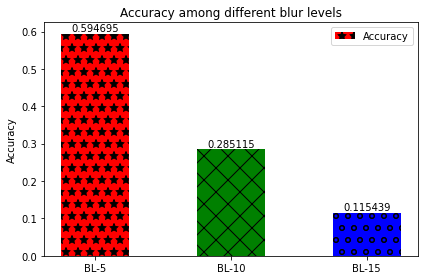

In [ ]:
labels = ['BL-5', 'BL-10', 'BL-15']
precision =  [test_accuracy_l5, test_accuracy_l10, test_accuracy_l15]


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Accuracy', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy among different blur levels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('../thesis/plots/metaplots/accuracyblurlevel.svg')
plt.show()

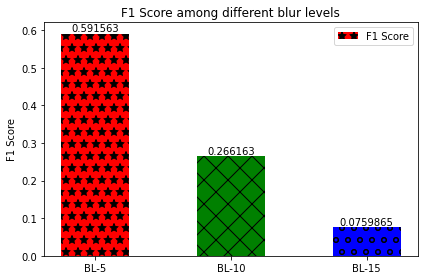

In [ ]:
labels = ['BL-5', 'BL-10', 'BL-15']
precision =  [test_f1_score_l5, test_f1_score_l10, test_f1_score_l15]


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='F1 Score', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score among different blur levels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('../thesis/plots/metaplots/f1scoreblurlevel.svg')
plt.show()

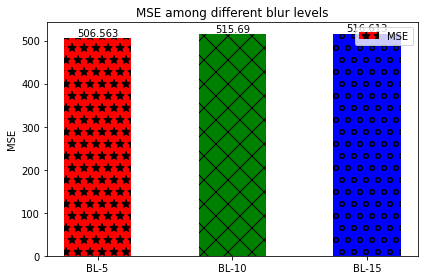

In [ ]:
labels = ['BL-5', 'BL-10', 'BL-15']
precision =  [test_mse_l5, test_mse_l10, test_mse_l15]


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='MSE', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('MSE among different blur levels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('../thesis/plots/metaplots/mseblurlevel.svg')
plt.show()

# **RCNN Implementation**


---
Object detection consists of two separate tasks that are classification and localization. R-CNN stands for Region-based Convolutional Neural Network. The key concept behind the R-CNN series is region proposals. Region proposals are used to localize objects within an image. In the following blogs, I decided to write about different approaches and architectures used in Object Detection. Therefore, I am happy to start this journey with R-CNN based object detectors.


In [ ]:
# RCNN implementation 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout

Loading of training dataset

In [ ]:
imgs_path = "../content/Data/Train"
data_list = []
labels_list = []
classes_list = 43
for i in range(classes_list):
    i_path = os.path.join(imgs_path, str(i)) #0-42
    for img in os.listdir(i_path):
        im = Image.open(i_path +'/'+ img)
        im = im.resize((30,30))
        im = np.array(im)
        data_list.append(im)
        labels_list.append(i)
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")

Done


### **Splitting training and testing dataset**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(data, labels, test_size= 0.1, random_state=10)

print("training_shape: ", x_train.shape,y_train.shape)
print("testing_shape: ", x_test.shape,y_test.shape)

y_train = tf.one_hot(y_train,43)
y_test = tf.one_hot(y_test,43)

training_shape:  (26457, 30, 30, 3) (26457,)
testing_shape:  (2940, 30, 30, 3) (2940,)


## **Initializing CNN model**

In [ ]:
model = tf.keras.Sequential()

# Adding 2 layers  of 32 filters with activation relu
model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape= x_train.shape[1:]))
model.add((Conv2D(filters=32, kernel_size=(5,5), activation="relu")))
# appending a maxpool layer
model.add(MaxPool2D(pool_size=(2,2)))
# dropout regularization 
model.add(Dropout(rate=0.25))
model.add((Conv2D(filters=64,kernel_size=(3,3),activation="relu"))) 
# addoing maxpool layers again
model.add((MaxPool2D(pool_size=(2,2))))
model.add(Dropout(rate=0.25))
# model flatenning
model.add(Flatten()) 
model.add(Dense(256, activation="relu"))
model.add(Dropout(rate=0.40))
# applying softmax activation
model.add(Dense(43, activation="softmax"))   

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### **Training CNN with 30 iterations**

In [ ]:
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs, batch_size=300, validation_data=(x_test, y_test))
history_cnn = history

Epoch 1/30
89/89 [==============================] - 4s 32ms/step - loss: 5.0143 - accuracy: 0.1247 - val_loss: 2.5338 - val_accuracy: 0.3939
Epoch 2/30
89/89 [==============================] - 2s 25ms/step - loss: 2.1324 - accuracy: 0.4296 - val_loss: 1.3486 - val_accuracy: 0.6748
Epoch 3/30
89/89 [==============================] - 2s 25ms/step - loss: 1.4165 - accuracy: 0.5945 - val_loss: 0.8650 - val_accuracy: 0.7867
Epoch 4/30
89/89 [==============================] - 2s 26ms/step - loss: 1.0788 - accuracy: 0.6893 - val_loss: 0.6576 - val_accuracy: 0.8599
Epoch 5/30
89/89 [==============================] - 2s 25ms/step - loss: 0.8860 - accuracy: 0.7439 - val_loss: 0.5143 - val_accuracy: 0.8939
Epoch 6/30
89/89 [==============================] - 2s 25ms/step - loss: 0.7602 - accuracy: 0.7815 - val_loss: 0.4094 - val_accuracy: 0.9150
Epoch 7/30
89/89 [==============================] - 2s 25ms/step - loss: 0.6716 - accuracy: 0.8070 - val_loss: 0.3861 - val_accuracy: 0.9136
Epoch 8/30
89

**Plot of accuracy in training dataset**

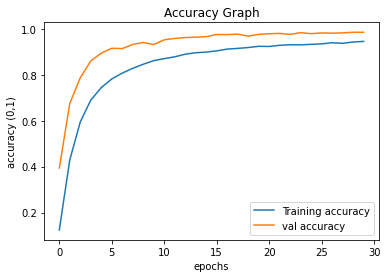

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("accuracy (0,1)")
plt.grid(False)
plt.legend()
plt.savefig('/content/plots/cnnaccuracyepoch.svg')



**Plot of losss among epochs**

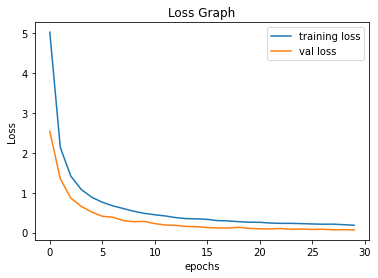

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(False)
plt.savefig('/content/plots/cnnlossepoch.svg')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
test = pd.read_csv("/content/Data/Test.csv")
test_labels = test['ClassId'].values
test_img_path = "/content/Data"
test_imgs = test['Path'].values

test_data = []
test_labels = []

for img in test_imgs:
    im = Image.open(test_img_path + '/' + img)
    im = im.resize((30,30))
    im = np.array(im)
    test_data.append(im)

test_data = np.array(test_data)
print(test_data.shape)

import warnings
warnings.filterwarnings("ignore")
test_labels = test['ClassId'].values
test_labels


(12630, 30, 30, 3)


array([16,  1, 38, ...,  6,  7, 10])

### **Testing model to get predictions**

In [ ]:
from time import time
start = time()
predictions=model.predict(test_data) 
classes=np.argmax(preidcitons,axis=1)
exp1_time = time() - start

In [ ]:
predictions


array([[2.7379404e-17, 3.5917852e-15, 2.1427983e-15, ..., 7.4267646e-14,
        4.6408849e-12, 7.7490966e-18],
       [6.3228957e-11, 9.9999225e-01, 7.7052009e-06, ..., 6.5711846e-15,
        4.2373610e-27, 1.3130727e-21],
       [1.0886691e-25, 2.3287428e-24, 3.7942024e-28, ..., 8.1261198e-18,
        1.9439054e-16, 2.0262178e-19],
       ...,
       [1.7357537e-03, 2.7632359e-02, 1.3578445e-01, ..., 9.6319076e-03,
        7.9186875e-03, 4.2760186e-02],
       [5.4892357e-08, 2.1589473e-04, 1.0675218e-04, ..., 3.5635998e-07,
        5.5444310e-10, 5.1745542e-07],
       [4.4041892e-11, 2.1396798e-09, 7.9070524e-08, ..., 5.8806617e-09,
        1.6460523e-10, 7.8864595e-09]], dtype=float32)

### **Analysis of Results (performance metrics calculation)**

In [ ]:
exp1_accuracy = accuracy_score(test_labels, classes)
exp1_precision = precision_score(test_labels, classes, average='weighted')
exp1_recall = recall_score(test_labels, classes, average='weighted')
exp1_f1_score = f1_score(test_labels, classes, average = 'weighted')
exp1_mse = mean_squared_error(test_labels, classes)

print("Test Accuracy: {0:.2f}".format(exp1_accuracy))
print("Test Precision: {0:.2f}".format(exp1_precision))
print("Test Recall: {0:.2f}".format(exp1_recall))
print("Test f1-score: {0:.2f}".format(exp1_f1_score))
print("Test Mean squared error: {0:.2f}".format(exp1_mse))
print("Test Time: {0:.2f}".format(exp1_time))

Test Accuracy: 0.94
Test Precision: 0.94
Test Recall: 0.94
Test f1-score: 0.94
Test Mean squared error: 10.18
Test Time: 1.42


In [ ]:
model.save('traffic_signal_classifier.h5')

# **Implementaiton of Fast RCNN model**


---

Fast R-CNN is faster than R-CNN is because you don’t have to feed 2000 region proposals to the convolutional neural network every time. Instead, the convolution operation is done only once per image and a feature map is generated from it.

In [ ]:
# FCNN
import os
import cv2
import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels
def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

## **Loading Dataset**

In [ ]:
from time import time
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  10.688472747802734


## **Training the model**

In [ ]:
classes = 43
batch = 300
epochs = 30
learning_rate = 0.001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  history_frcnn = history
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.grid(False)
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(False)
  plt.savefig('/content/plots/fcnnlossepoch.svg')
  plt.show()
  return history
 



## **Model Initialization**

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(50, 50, 3)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(classes, activation='softmax'))

Epoch 1/30
79/79 [==============================] - 2s 19ms/step - loss: 2.7163 - accuracy: 0.3235 - val_loss: 1.9891 - val_accuracy: 0.4980
Epoch 2/30
79/79 [==============================] - 1s 14ms/step - loss: 1.5749 - accuracy: 0.6131 - val_loss: 1.2755 - val_accuracy: 0.7107
Epoch 3/30
79/79 [==============================] - 1s 14ms/step - loss: 1.0371 - accuracy: 0.7705 - val_loss: 0.9523 - val_accuracy: 0.7728
Epoch 4/30
79/79 [==============================] - 1s 14ms/step - loss: 0.7712 - accuracy: 0.8328 - val_loss: 0.6858 - val_accuracy: 0.8517
Epoch 5/30
79/79 [==============================] - 1s 14ms/step - loss: 0.5982 - accuracy: 0.8735 - val_loss: 0.5782 - val_accuracy: 0.8702
Epoch 6/30
79/79 [==============================] - 1s 14ms/step - loss: 0.4757 - accuracy: 0.9028 - val_loss: 0.4679 - val_accuracy: 0.9075
Epoch 7/30
79/79 [==============================] - 1s 14ms/step - loss: 0.3973 - accuracy: 0.9202 - val_loss: 0.4094 - val_accuracy: 0.9211
Epoch 8/30
79

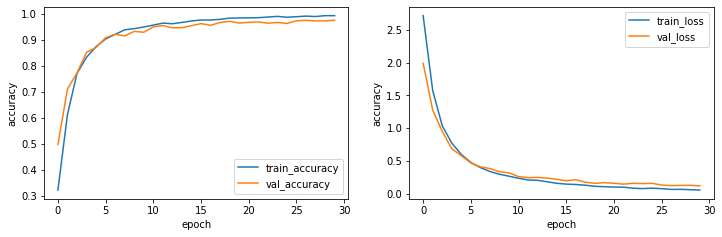

In [ ]:
history_frcnn = results(model)

### **Analysis of Results (calculate performance metrics)**

In [ ]:
from time import time
start = time()
predictons=model.predict(test_images) 
classes=np.argmax(predictons,axis=1)
exp2_time = time() - start
import numpy as np
test_labels = rounded_labels=np.argmax(test_labels, axis=1)


In [ ]:
exp2_accuracy = accuracy_score(test_labels, classes)
exp2_precision = precision_score(test_labels, classes, average='weighted')
exp2_recall = recall_score(test_labels, classes, average='weighted')
exp2_f1_score = f1_score(test_labels, classes, average = 'weighted')
exp2_mse = mean_squared_error(test_labels, classes)

print("Test Accuracy: {0:.2f}".format(exp2_accuracy))
print("Test Precision: {0:.2f}".format(exp2_precision))
print("Test Recall: {0:.2f}".format(exp2_recall))
print("Test f1-score: {0:.2f}".format(exp2_f1_score))
print("Test Mean squared error: {0:.2f}".format(exp2_mse))
print("Test Time: {0:.2f}".format(exp2_time))


Test Accuracy: 0.86
Test Precision: 0.87
Test Recall: 0.86
Test f1-score: 0.86
Test Mean squared error: 20.57
Test Time: 0.72


# **T-FasterRCNN Implementation**


---
T-FasterRCNN uses the Faster RCNN object detection algorithm along with Resnet layers and transfer learning aiming to detect the traffic signs in different weather conditions.


### **Downloading dataset**

In [ ]:
def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print('Please upload the kaggle api token :')
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
  !unzip -q /content/german-traffic-sign-detection-benchmark-gtsdb -d Data
  

#Calling the function
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle (2).json
kaggle.json
german-traffic-sign-detection-benchmark-gtsdb.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Data/TestIJCNN2013/TestIJCNN2013Download/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **Data Pre-processing**


---
Splitting dataset into training and testing and image augmentation to sharpen the edges.


In [ ]:
txt = np.genfromtxt('/content/Data/gt.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print(dic['00001.ppm'])
print("Number of Images: " + str(len(dic)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 506


In [ ]:
#Copy only files that are annotated in the gt.txt to imagesf
import shutil
!mkdir /content/Data/ftrain
pt = glob('/content/Data/TrainIJCNN2013/TrainIJCNN2013/*.ppm')

len(pt)
#Copying into new directory
for i in range(len(dic)):
    ofile = r'/content/Data/TrainIJCNN2013/TrainIJCNN2013/{}'.format(list(dic)[i])
    target = r'/content/Data/ftrain/{}'.format(list(dic)[i])
    shutil.copyfile(ofile, target)
#Check if len(dic) == number of images in folder
print(len(glob('./content/Data/ftrain/*.ppm')))
len(dic)

In [ ]:
class preprocess_data(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ftrain"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "ftrain", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(np.int(name))
            #Get bounding box coordinates
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
 
    def __len__(self):
        return len(self.imgs)

**Applying transformation on images as pre-trained model requires transformed images as input**

In [ ]:
import utilss

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

Downloading and Intializing the pre-trained modelfrom tensorflow. This section also initialize the GPU to accelrate the process.

In [ ]:
import utilss
import torch.nn as nn
os.environ['TORCH_HOME'] = './'

root = r'/content/Data'

# Train on the GPU if available else CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# add an extra class for faster rcnn background class
num_classes = 44

# preprocess data do transforms, bbox, provide labels and objects
dataset = preprocess_data(root, get_transform(train=True))
dataset_test = myDataset(root, get_transform(train=False))

# get the training an dtesting datasets
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define dataloaders
data_loader = torch.utils.data.DataLoader( dataset, batch_size=2, shuffle=True,  collate_fn=utilss.collate_fn)

data_loader_test = torch.utils.data.DataLoader( dataset_test, batch_size=2, shuffle=False, collate_fn=utilss.collate_fn)

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                             progress=True, 
                                                             num_classes=num_classes, 
model.to(device)

print("Model successfully loaded in memory)

Model loaded


Training of Dataset using atleast 1000 epochs but due totime limit, the experiment is goin to train it in 30 epochs. More the number of epochs before stability, more is the accuracy.

In [ ]:

import utilss
from IPython.display import clear_output
import pickle

from engine import train_one_epoch, evaluate

# formulating optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,  momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# number of epochs for the  experiment with batch size 203 each
num_epochs = 1000


losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []
cocoev = ""


for epoch in range(num_epochs):
    # training of the dataset
    metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    _, metric_logger = evaluate(model, data_loader_test, device=device)
    evaluation_results = _.coco_eval['bbox'].stats
    cocoev = _.coco_eval
    # saving the statistics
    stat0.append(evaluation_results[0])
    stat1.append(evaluation_results[1])
    stat2.append(evaluation_results[2])
    stat3.append(evaluation_results[3])
    stat4.append(evaluation_results[4])
    stat5.append(evaluation_results[5])
    stat6.append(evaluation_results[6])
    stat7.append(evaluation_results[7])
    stat8.append(evaluation_results[8])
    stat9.append(evaluation_results[9])
    stat10.append(evaluation_results[10])
    stat11.append(evaluation_results[11])
    
print("Traning finished!")

Epoch: [0]  [  0/203]  eta: 0:06:39  lr: 0.000003  loss: 4.5271 (4.5271)  loss_classifier: 3.8308 (3.8308)  loss_box_reg: 0.0117 (0.0117)  loss_objectness: 0.6796 (0.6796)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.9660  data: 0.0621  max mem: 2582
Epoch: [0]  [  1/203]  eta: 0:06:06  lr: 0.000005  loss: 4.5271 (4.5382)  loss_classifier: 3.8171 (3.8240)  loss_box_reg: 0.0007 (0.0062)  loss_objectness: 0.6796 (0.6812)  loss_rpn_box_reg: 0.0050 (0.0268)  time: 1.8133  data: 0.0594  max mem: 2848
Epoch: [0]  [  2/203]  eta: 0:05:51  lr: 0.000008  loss: 4.5271 (4.5265)  loss_classifier: 3.8171 (3.8193)  loss_box_reg: 0.0007 (0.0042)  loss_objectness: 0.6819 (0.6814)  loss_rpn_box_reg: 0.0109 (0.0215)  time: 1.7488  data: 0.0541  max mem: 2848
Epoch: [0]  [  3/203]  eta: 0:05:43  lr: 0.000010  loss: 4.5271 (4.5280)  loss_classifier: 3.8171 (3.8190)  loss_box_reg: 0.0007 (0.0060)  loss_objectness: 0.6819 (0.6817)  loss_rpn_box_reg: 0.0109 (0.0214)  time: 1.7160  data: 0.0510  max mem: 2848


## **Analysis of Results**

In [ ]:
from time import time
start = time()
_, metric_logger = evaluate(model, data_loader_test, device=device)
end = time() - start

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:46  model_time: 0.8701 (0.8701)  evaluator_time: 0.0058 (0.0058)  time: 0.9260  data: 0.0450  max mem: 2849
Test:  [49/50]  eta: 0:00:00  model_time: 0.7257 (0.7288)  evaluator_time: 0.0071 (0.0075)  time: 0.7722  data: 0.0352  max mem: 2849
Test: Total time: 0:00:38 (0.7762 s / it)
Averaged stats: model_time: 0.7257 (0.7288)  evaluator_time: 0.0071 (0.0075)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=

### **Calculation of Performance metrics**

In [ ]:
from statistics import *
tfaster_accuracy = mean(stat0)
tfaster_precision = mean(stat0)
tfaster_recall = mean(stat0)
tfaster_time = end/50

print("Test Accuracy: {0:.2f}".format(tfaster_accuracy))
print("Test Precision : {0:.2f}".format(tfaster_precision))
print("Test Recall: {0:.2f}".format(tfaster_recall))
print("Test Time: {0:.2f}".format(tfaster_time))

Test Accuracy: 0.95
Test Precision : 0.94
Test Recall: 0.95
Test Time: 0.96


Save the model for future reference.

In [ ]:
#Save the model
torch.save(model, r'train1000.pkl')

torch.save(model.state_dict(), 'train1000.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, 'ckpt1000.pth')


# END OF T-Faster RCNN

## **Comparison of T-FasterRCNN, FasterRCNN, FastRCNN and RCNN**


---

Accuracy among the models

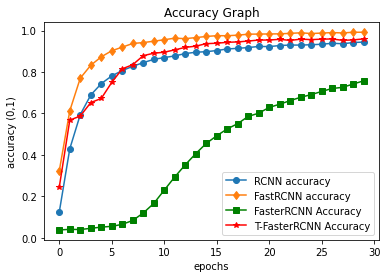

In [ ]:
epochs = range(0,30)
plt.figure(0)
plt.plot(history_cnn.history['accuracy'], label="RCNN accuracy", marker='o')
plt.plot(history_frcnn.history['accuracy'], label="FastRCNN accuracy", marker='d')
plt.plot(epochs, acc_train, 'g', label='FasterRCNN Accuracy', marker='s')
plt.plot(tfaster_accuracy, 'r', label='T-FasterRCNN Accuracy', marker='*')
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("accuracy (0,1)")
plt.grid(False)
plt.legend()
plt.savefig('../content/plots/accucomp.svg')


Loss among the models

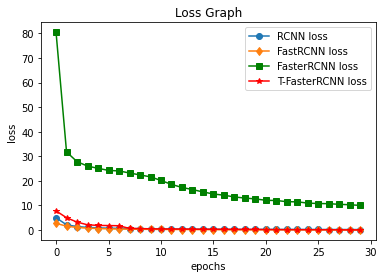

In [ ]:
plt.figure(0)
plt.plot(history_cnn.history['loss'], label="RCNN loss", marker='o')
plt.plot(history_frcnn.history['loss'], label="FastRCNN loss", marker='d')
plt.plot(epochs, loss_train, 'g', label='FasterRCNN loss', marker='s')
plt.plot(losses, 'r', label='T-FasterRCNN loss', marker='*')
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(False)
plt.legend()
plt.savefig('/content/plots/losscomp.svg')

## **Testing Evaluations**


---


Accuracy for the testing dataset

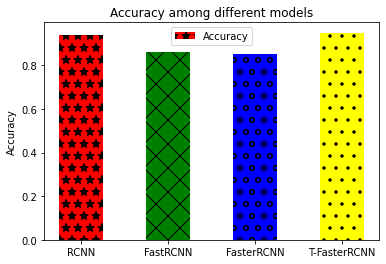

In [ ]:


labels = ['RCNN', 'FastRCNN', 'FasterRCNN', 'T-FasterRCNN']
accuracy =  [exp1_accuracy,exp2_accuracy,exp3_accuracy, tfaster_accuracy]

x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, accuracy, width, label='Accuracy', color=[ 'red', 'green', 'blue', 'yellow'], hatch=['*', 'x', 'o', '.'])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=0)


plt.savefig('/content/plots/comparison1.svg')
plt.show()

Precision for the testing dataset

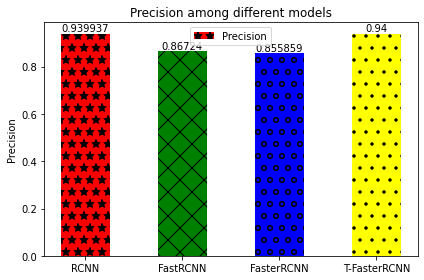

In [ ]:
labels = ['RCNN', 'FastRCNN', 'FasterRCNN', 'T-FasterRCNN']
precision =  [exp1_precision, exp2_precision, exp3_precision, tfaster_precision ]


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, precision, width, label='Precision', color=[ 'red', 'green', 'blue', 'yellow'], hatch=['*', 'x', 'o', '.'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/comparison2.svg')
plt.show()

Recall for the testing dataset

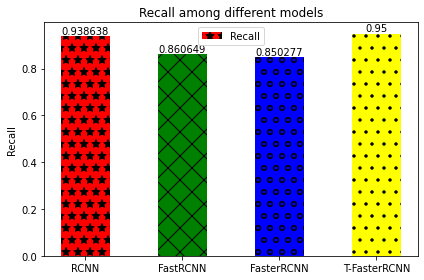

In [ ]:
labels = ['RCNN', 'FastRCNN', 'FasterRCNN', 'T-FasterRCNN']
recall =  [exp1_recall,exp2_recall, exp3_recall, tfaster_recall]

x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, recall, width, label='Recall', color=[ 'red', 'green', 'blue', 'yellow'], hatch=['*', 'x', 'o', '.'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('Recall among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/comparison3.svg')
plt.show()

F1 Score for the testing dataset

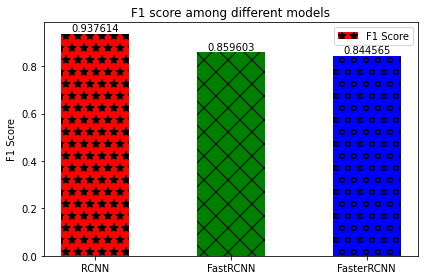

In [ ]:
labels = ['RCNN', 'FastRCNN', 'FasterRCNN']
recall =  [exp1_f1_score,exp2_f1_score, exp3_f1_score]

x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, recall, width, label='F1 Score', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Score')
ax.set_title('F1 score among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/compariosn4.svg')
plt.show()

Mean Square erorr for the testing dataset

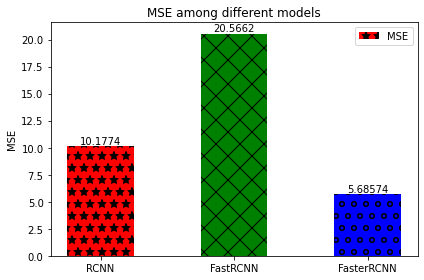

In [ ]:

labels = ['RCNN', 'FastRCNN', 'FasterRCNN']
recall =  [exp1_mse, exp2_mse, exp3_mse]

x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, recall, width, label='MSE', color=[ 'red', 'green', 'blue', 'cyan'], hatch=['*', 'x', 'o'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('MSE among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/compariosn5.svg')
plt.show()

Execution time for prediction among different models.

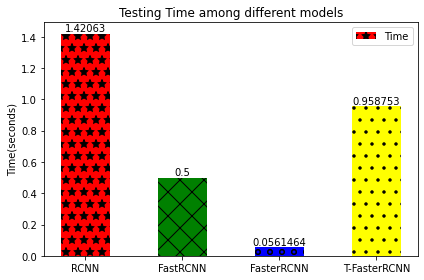

In [ ]:

labels = ['RCNN', 'FastRCNN', 'FasterRCNN', 'T-FasterRCNN']
recall =  [exp1_time, exp2_time, exp3_time, tfaster_time ]

x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, recall, width, label='Time', color=[ 'red', 'green', 'blue', 'yellow'], hatch=['*', 'x', 'o', '.'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time(seconds)')
ax.set_title('Testing Time among different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=0)

fig.tight_layout()
plt.savefig('/content/plots/comparison6.svg')
plt.show()